In [1]:
# 需要先安裝 gym[atari]
# headless 執行: xvfb-run -a jupyter notebook
import gym

In [2]:
env = gym.make('Pong-ram-v0')

[2017-10-24 20:15:40,051] Making new env: Pong-ram-v0


In [3]:
import numpy as np
import ipywidgets as W
from PIL import Image

看一下基本資訊

In [4]:
env.action_space

Discrete(6)

In [5]:
env.reward_range

(-inf, inf)

In [6]:
env.reset()

array([192,   0,   0,   0, 110,  38,   0,   7,  63,   1,  60,  59,   0,
         0,   0,  62, 255,   0, 255, 253,   0,   8,   0,  24, 128,  32,
         1,  86, 247,  86, 247,  86, 247, 134, 243, 245, 243, 240, 240,
       242, 242,  32,  32,  64,  64,  64, 188,  65, 189,   0,   8, 109,
        37,  37,  60,   0,   0,   0,   0, 109, 109,  37,  37, 192, 192,
       192, 192,   1, 192, 202, 247, 202, 247, 202, 247, 202, 247,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  54, 236, 242, 121, 240], dtype=uint8)

抓圖出來

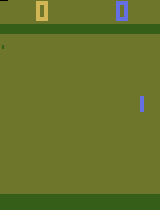

In [7]:
Image.fromarray(env.render(mode='rgb_array'))

In [8]:
from io import BytesIO
def to_png(a):
    with BytesIO() as bio:
        Image.fromarray(a).save(bio, 'png')
        return bio.getvalue()

觀察

In [9]:
from functools import partial
last_ob = None
def pressed(a, x):
    global last_ob
    observation, reward, done, info = env.step(a)
    img = env.render(mode='rgb_array')
    screen.value = to_png(img)
    txt.value = "{} {} {} {:02x} {:02x} {:02x}".format(reward, done, info, 
                                                       observation[49],observation[54], observation[60] )
    h = "<table>"
    for i in range(8):
        h+="<tr>"
        for j in range(16):
            color = 'black'
            if last_ob is not None:
                if last_ob[16*i+j]!=observation[16*i+j]:
                    color='red'
            h+="<td style='width: 2.5em;color: %s'>%02X</td>"%(color, observation[16*i+j])
        h+="</tr>"
    h+="</table"
    html.value=h
    last_ob = observation.copy()
buttons = [W.Button(description=str(i)) for i in range(6)]
for i in range(6):
    buttons[i].on_click(partial(pressed,i))
txt = W.Text()
screen = W.Image()
html = W.HTML()
display(W.HBox([screen, W.VBox(buttons), W.VBox([txt, html])]))
env.reset();


HBox(children=(Image(value=b''), VBox(children=(Button(description='0', style=ButtonStyle()), Button(description='1', style=ButtonStyle()), Button(description='2', style=ButtonStyle()), Button(description='3', style=ButtonStyle()), Button(description='4', style=ButtonStyle()), Button(description='5', style=ButtonStyle()))), VBox(children=(Text(value=''), HTML(value='')))))

找到適當參數後， 手刻 AI

In [10]:
from time import sleep
screen = W.Image()
display(screen)
observation = env.reset()
wait = 0
for i in range(50):
    env.step(0)
for i in range(8000):
    x,y0 = observation[[49,54]]
    y2 = observation[60]
    dy = (observation[56]+127)%256-127
    dx = (observation[58]+127)%256-127
    if i>0:
        assert dx ==1 or dx ==-1
        if dx < 0:
            assert x>0x40 and x<210
            assert dy>-4 and dy < 4
            assert y0>=30 and y0<=210
            assert y2>=30 and y2<=210
    if dx < 0:
        y = (int(y0 - (186-x)*dy/dx)-44)%(326)
        if y>163:
            y=326-y
        y+=38
    else:
        y=115
    if y2<y-3:
        if 40<y-y2 or wait<=0:
            a = 3
            wait=(40-(y-y2))//8
        else:
            wait-=1
            a=0
    elif y2 > y+3:
        if y2-y>40 or wait<=0:
            a = 2
            wait=(40-(y2-y))//8
        else:
            wait-=1
            a = 0
    else:
        a = 0
        wait =0
    observation, reward, done, info = env.step(a)
    img = env.render(mode='rgb_array')
    screen.value = to_png(img)
    sleep(1/60)

Image(value=b'')

AssertionError: 

In [ ]:
y0, dx

In [11]:
img = env.render(mode='rgb_array')
screen.value = to_png(img)

用 Tabular Q learning 試試看， 狀態為預測的落點以及目前的位置之間的差距

In [71]:
from time import sleep
from random import randint, random, shuffle, choice

α = 1e-2
γ = 0.9
ϵ = .1

Q=np.zeros((100,3))
actions = [0,2,3]
def compute_s(observation):
    dx = (observation[58]+127)%256-127
    if dx>=0:
        return 0    
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]    
    y = (int(y0 - (186-x)*dy/dx)-44)%(326)
    if y>163:
        y=326-y
    y+=38
    s = (y-y2)//2
    if s<-49:
        s=-49
    elif s>49:
        s=49
    return s+50

def Qlearn(test=False, screen=None, T=40):
    observation = env.reset()
    for i in range(50):
        observation, reward, done, info =env.step(choice(actions))
    s2 = compute_s(observation)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        elif s == 0:
            a = choice(actions)
        else:
            a = actions[np.argmax(Q[s])]
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation)
        r = reward
        total_r+=r
        if not test and s!=0:
            if s2==0:
                r=1
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
            #if r!=0:
                #return total_r
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

Image(value=b'')

Text(value='')

0 -0.86 0.1
200 -0.04 0.1


KeyboardInterrupt: 

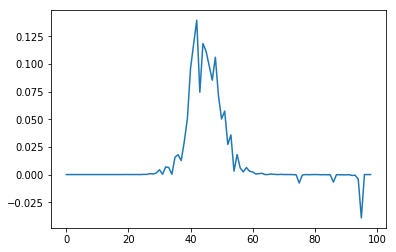

In [61]:
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
ϵ = .1
α = 1e-2
γ = 1
r = -20
for j in range(1001):
    if j%20==0:
        txt.value="j={} r={} {} ".format(j, r/20,  ϵ)
        plt.clf()
        plt.plot(Q[1:].max(axis=1))        
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=0
            for i in range(50):
                r+=Qlearn(test=True)
            print(j, r/50, ϵ)
        r=0

    r+=Qlearn()


In [78]:
from time import sleep
from random import randint, random, shuffle, choice

α = 1e-2
γ = 0.9
ϵ = .1

Q=np.zeros((3, 100,3))
actions = [0,2,3]
last_a=0
def compute_s(observation, a):
    global last_a
    a = max(0, a-1)
    last_a, a0 = a, last_a
    dx = (observation[58]+127)%256-127
    if dx>=0:
        return 0    
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]    
    y = (int(y0 - (186-x)*dy/dx)-44)%(326)
    if y>163:
        y=326-y
    y+=38
    s = (y-y2)//2
    if s<-49:
        s=-49
    elif s>49:
        s=49
    return a0, s+50

def Qlearn(test=False, screen=None, T=40):
    observation = env.reset()
    for i in range(50):
        a = choice(actions)
        observation, reward, done, info =env.step(a)
        s2 = compute_s(observation, a)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        elif s==0:
            a = choice(actions)
        else:            
            a = actions[np.argmax(Q[s])]
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation, a)
        r = reward
        total_r+=r
        if not test and s!=0:
            if s2==0:
                r=1
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
            #if r!=0:
                #return total_r
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

Image(value=b'')

Text(value='')

0 -20.9 3.1
200 -9.75 0.4153369920596814
400 -2.25 0.1
600 -1.3 0.1
800 -0.9 0.1
1000 -0.75 0.1
1200 0.1 0.1
1400 -0.2 0.1
1600 -1.85 0.1
1800 -1.8 0.1
2000 -1.45 0.1
2200 -1.9 0.1
2400 -2.2 0.1
2600 -2.4 0.1
2800 -2.1 0.1
3000 -2.45 0.1
3200 -2.4 0.1
3400 -1.95 0.1
3600 -1.4 0.1
3800 -3.25 0.1
4000 -3.4 0.1
4200 -1.95 0.1
4400 -2.1 0.1
4600 -2.05 0.1
4800 -2.25 0.1
5000 -2.3 0.1
5200 -2.25 0.1
5400 -3.8 0.1
5600 -3.8 0.1
5800 -2.0 0.1
6000 -1.55 0.1
6200 -1.75 0.1
6400 -2.1 0.1
6600 -2.9 0.1
6800 -2.55 0.1
7000 -0.6 0.1
7200 -2.2 0.1
7400 -3.8 0.1
7600 -2.05 0.1
7800 -1.3 0.1
8000 -2.0 0.1
8200 -1.4 0.1
8400 -2.3 0.1
8600 -1.35 0.1
8800 -2.2 0.1
9000 -1.5 0.1
9200 -2.15 0.1
9400 -2.15 0.1
9600 -2.7 0.1
9800 -1.6 0.1
10000 -2.85 0.1
10200 -2.95 0.1
10400 -2.1 0.1
10600 -2.35 0.1
10800 -3.2 0.1
11000 -2.85 0.1
11200 -3.05 0.1
11400 -2.9 0.1
11600 -2.65 0.1
11800 -1.4 0.1
12000 -1.75 0.1
12200 -1.9 0.1
12400 -1.75 0.1
12600 -1.6 0.1
12800 -1.15 0.1
13000 -1.2 0.1
13200 -1.75 0.1
13400 -1

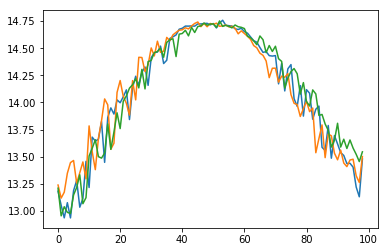

In [79]:
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
ϵ = 3.1
α = 1e-2
γ = 1
r = -20
for j in range(20001):
    if j%20==0:
        txt.value="j={} r={} {} ".format(j, r/20,  ϵ)
        plt.clf()
        plt.plot(Q[0, 1:].max(axis=1))
        plt.plot(Q[1, 1:].max(axis=1))
        plt.plot(Q[2, 1:].max(axis=1))
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=0
            for i in range(20):
                r+=Qlearn(test=True, T=1400)
            print(j, r/20, ϵ)
        r=0

    r+=Qlearn(T=1400)
    ϵ = max(0.1, ϵ*0.99)


In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

Image(value=b'')

Text(value='')

0 -0.8 0.1
200 -0.46 0.1
400 -0.2 0.1
600 -0.1 0.1
800 -0.06 0.1
1000 -0.14 0.1


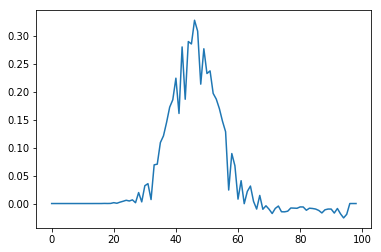

In [14]:
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
ϵ = .1
α = 1e-2
γ = 1
r = -20
for j in range(1001):
    if j%20==0:
        txt.value="j={} r={} {} ".format(j, r/20,  ϵ)
        plt.clf()
        plt.plot(Q[1:].max(axis=1))
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=0
            for i in range(50):
                r+=Qlearn(test=True)
            print(j, r/50, ϵ)
        r=0

    r+=Qlearn()


### 測試一下

In [21]:
screen = W.Image()
display(screen)
Qlearn(test=True, screen=screen, T=40)

Image(value=b'')

0.0

### 多打幾球

Image(value=b'')

Text(value='')

0 -7.1 0.1
200 -2.5 0.1
400 -0.85 0.1
600 -1.2 0.1
800 -0.2 0.1
1000 -0.55 0.1
1200 -0.8 0.1
1400 -0.3 0.1
1600 -0.65 0.1
1800 -0.15 0.1
2000 -0.55 0.1


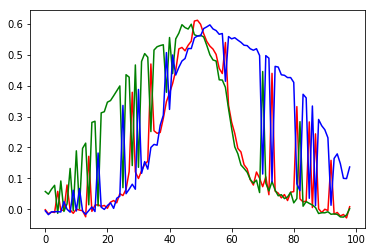

In [72]:
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
ϵ = .1
α = 1e-2
γ = 1
for j in range(2001):
    if j%10==0:
        txt.value="j={} r={} {} ".format(j, r/10,  ϵ)
        plt.clf()
        plt.plot(Q[1:,0],'r')
        plt.plot(Q[1:,1],'g')
        plt.plot(Q[1:,2],'b')
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=0
            for i in range(20):
                r+=Qlearn(test=True, T=400)
            print(j, r/20, ϵ)
        r=0

    r+=Qlearn(T=400)


In [73]:
# 測試一下
screen = W.Image()
display(screen)
Qlearn(test=True, screen=screen, T=400)

Image(value=b'')

-1.0

直接用原來的狀態，會有比較大的 state space

狀態太大，要花比較久的時間學習


In [30]:
from time import sleep
from random import randint, random, shuffle, choice

α = 1e-2
γ = 1
ϵ = .1

# x y0 y2 dy, a
Q=np.zeros((105, 105, 105, 20, 3))
actions = [0,2,3]
def compute_s(observation):
    dx = (observation[58]+127)%256-127
    if dx>=0:
        return None
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]
    assert 0<=x<210
    assert -9<=dy<=9
    return (x//2,y0//2,y2//2,dy+9)

def Qlearn2(test=False, screen=None, T=300):
    observation = env.reset()
    for i in range(50):
        observation, reward, done, info =env.step(0)
    s2 = compute_s(observation)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        elif s is None:
            a = choice(actions)
        else:
            try:
                a = actions[np.argmax(Q[s])]
            except:
                print(s)
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation)
        r = reward
        total_r+=r
        if not test and s is not None:
            if s2 is None:
                r=1.
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

Image(value=b'')

Text(value='')

99 -6.7
199 -6.0
299 -4.9
399 -5.5
499 -5.2
599 -4.9
699 -5.3
799 -4.7
899 -3.8
999 -3.2
1099 -3.6
1199 -3.2
1299 -3.0
1399 -2.5
1499 -2.5
1599 -3.2
1699 -3.5
1799 -2.8
1899 -2.7
1999 -3.2
2099 -3.3
2199 -3.6
2299 -3.1
2399 -2.5
2499 -3.3
2599 -2.7
2699 -2.2
2799 -2.5
2899 -3.3
2999 -2.7
3099 -3.0
3199 -2.4
3299 -3.1
3399 -2.8
3499 -2.6
3599 -2.8
3699 -2.2
3799 -2.9
3899 -2.7
3999 -1.6
4099 -2.4
4199 -2.6
4299 -2.4
4399 -2.8
4499 -2.8
4599 -2.7
4699 -3.0
4799 -2.4
4899 -2.7
4999 -2.3
5099 -2.9
5199 -2.2
5299 -2.2
5399 -2.7
5499 -2.4
5599 -2.6
5699 -2.7
5799 -1.9
5899 -2.7
5999 -2.3
6099 -2.8
6199 -2.7
6299 -2.4
6399 -2.3
6499 -3.1
6599 -2.9
6699 -3.4
6799 -2.5
6899 -2.8
6999 -2.2
7099 -3.2
7199 -2.8
7299 -2.5
7399 -2.0
7499 -2.2
7599 -1.8
7699 -3.2
7799 -2.4
7899 -3.0
7999 -1.7
8099 -3.1
8199 -2.2
8299 -2.2
8399 -3.1
8499 -2.7
8599 -2.8
8699 -3.1
8799 -2.5
8899 -2.4
8999 -1.9
9099 -2.1
9199 -2.7
9299 -2.4
9399 -3.0
9499 -2.3
9599 -2.6
9699 -2.8
9799 -3.0
9899 -2.5
9999 -2.7
10099 -2.2


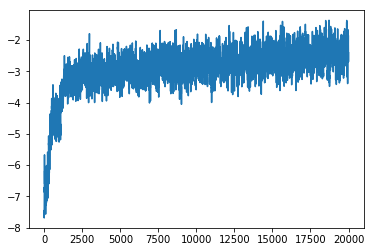

In [32]:
screen = W.Image()
display(screen)
α = 1e-2
γ = 1
ϵ = .1
txt =W.Text()
display(txt)
r = 0
rr= -8
rate = []
for j in range(20001):
    if j%100==99:
        r=0
        for i in range(10):
            r+=Qlearn2(test=True, T=400)
        print(j, r/10)
    rr = rr*0.9 + 0.1*Qlearn2(T=400)
    rate.append(rr)
    txt.value="j={} r={}".format(j,rr)
    plt.clf()
    plt.plot(rate)
    with BytesIO() as bio:
        plt.savefig(bio)
        screen.value = bio.getvalue()


In [35]:
# 測試
screen = W.Image()
display(screen)
Qlearn2(test=True, screen=screen, T=400)

Image(value=b'')

-1.0